In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn 및 TensorFlow 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2

# --- 1. 데이터 로드 ---
try:
    data = pd.read_csv('./predictive_maintenance.csv')
    print("데이터 로드 완료.")
except FileNotFoundError:
    print("오류: ./predictive_maintenance.csv 파일을 찾을 수 없습니다.")

데이터 로드 완료.


In [3]:
# 불필요한 컬럼 및 원본 데이터의 다중 클래스 고장 유형 컬럼 제거
data_cleaned = data.drop(['UDI', 'Product ID', 'Failure Type'], axis=1)

# --- 2. EDA (탐색적 데이터 분석) ---

print("\n--- 데이터 기본 정보 ---")
data_cleaned.info()
print("\n--- 데이터 기술 통계 ---")
print(data_cleaned.describe())


--- 데이터 기본 정보 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Target                   10000 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 547.0+ KB

--- 데이터 기술 통계 ---
       Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
count         10000.000000             10000.000000            10000.000000   
mean            300.004930               310.005560             1538.776100   
std               2.000259                 1.483734              179


EDA 1: 'target_distribution.png' 저장 완료.


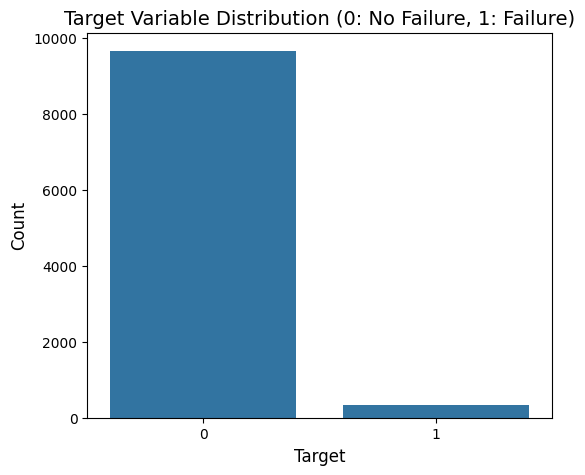

In [4]:
# EDA 1: 타겟 변수 분포 시각화 (데이터 불균형 확인)
plt.figure(figsize=(6, 5))
sns.countplot(x='Target', data=data_cleaned)
plt.title('Target Variable Distribution (0: No Failure, 1: Failure)', fontsize=14)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.savefig('target_distribution.png')
print("\nEDA 1: 'target_distribution.png' 저장 완료.")
plt.show()

EDA 2: 'feature_distributions.png' 저장 완료.


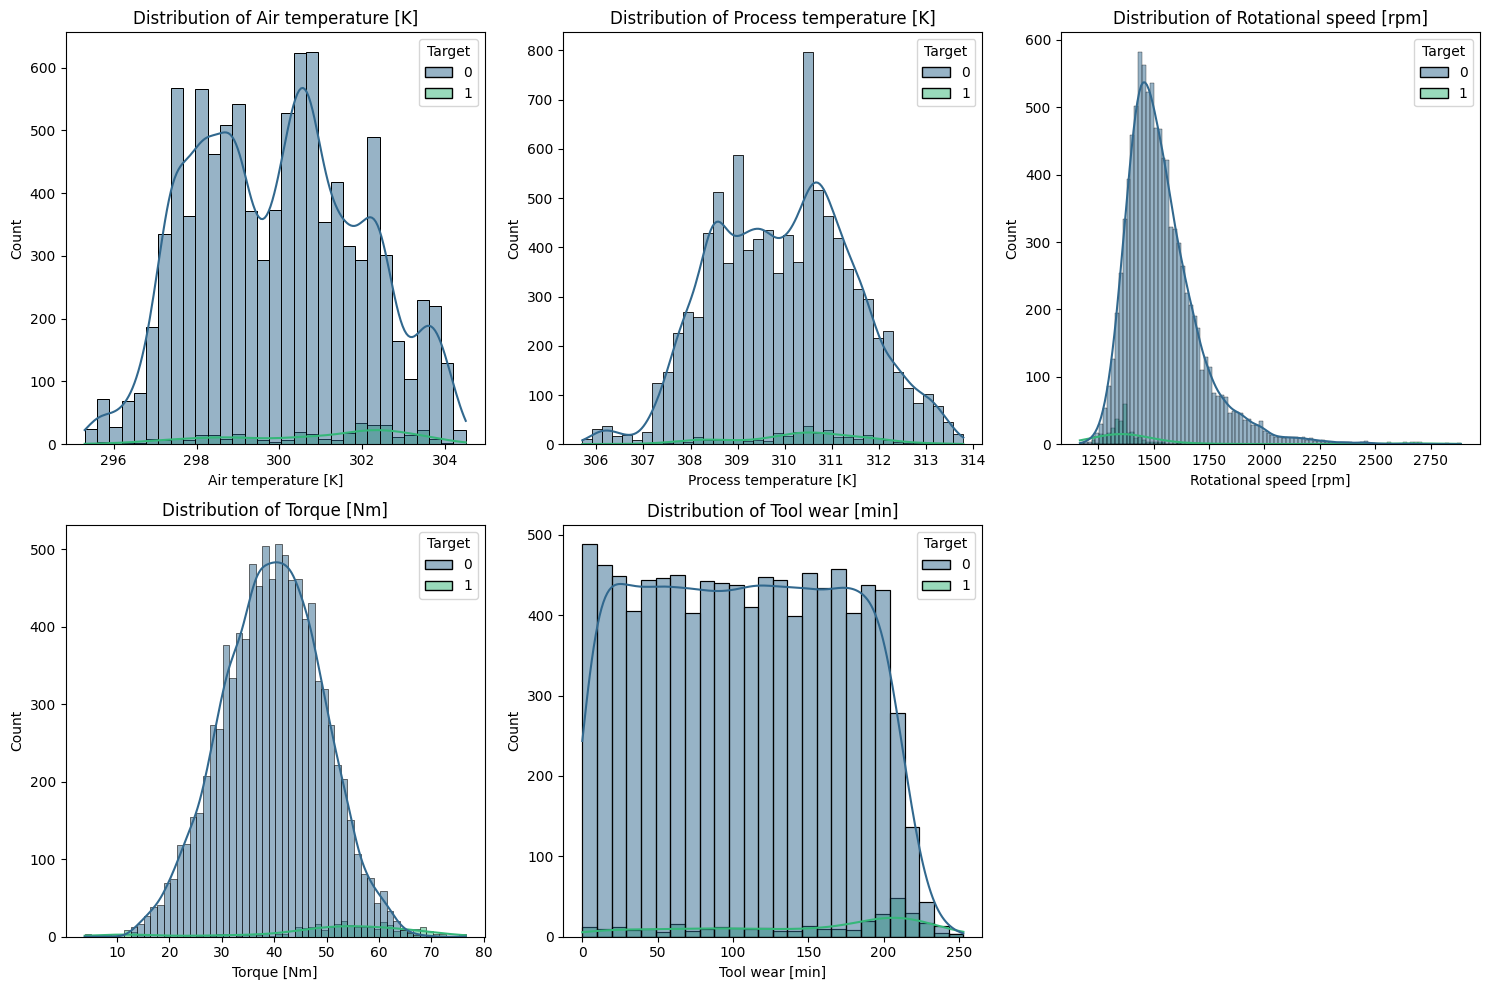

In [5]:
# EDA 2: 주요 수치 데이터 분포 시각화
numerical_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data=data_cleaned, x=col, hue='Target', kde=True, palette='viridis')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.savefig('feature_distributions.png')
print("EDA 2: 'feature_distributions.png' 저장 완료.")
plt.show()

EDA 3: 'correlation_heatmap.png' 저장 완료.


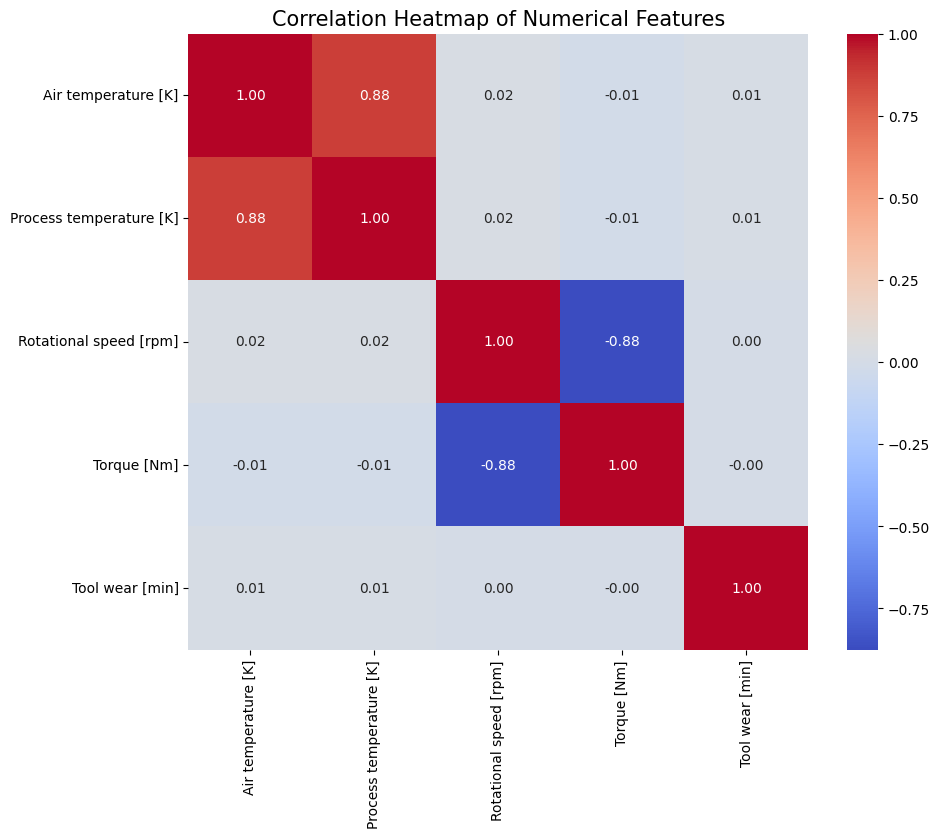

In [6]:
# EDA 3: 상관관계 히트맵
plt.figure(figsize=(10, 8))
corr = data_cleaned[numerical_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features', fontsize=15)
plt.savefig('correlation_heatmap.png')
print("EDA 3: 'correlation_heatmap.png' 저장 완료.")
plt.show()

In [7]:
# --- 3. 데이터 전처리 (데이터 누수 해결 및 개선) ---

# 특징(X)과 타겟(y) 분리 (데이터 누수 원인 제거)
X = data_cleaned.drop('Target', axis=1)
y = data_cleaned['Target']

# 범주형 변수 'Type'을 원-핫 인코딩
X = pd.get_dummies(X, columns=['Type'], drop_first=True)

# 훈련 데이터와 테스트 데이터 분할 (stratify 옵션으로 클래스 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 수치형 데이터 스케일링 (훈련 데이터 기준으로만 fit)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 타겟 변수 원-핫 인코딩
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

print(f"\n훈련 데이터 형태: {X_train_scaled.shape}, {y_train_cat.shape}")
print(f"테스트 데이터 형태: {X_test_scaled.shape}, {y_test_cat.shape}")


훈련 데이터 형태: (8000, 7), (8000, 2)
테스트 데이터 형태: (2000, 7), (2000, 2)


In [8]:
# --- 4. 모델 구축 및 훈련 ---
# 원본 코드의 모델 구조와 동일
def create_model(input_shape):
    inputs = Input(input_shape)
    x = Dense(1024, activation='relu', kernel_regularizer=l2())(inputs)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(inputs, x)
    model.compile(loss=CategoricalCrossentropy(), metrics=['accuracy'], optimizer=Adam(5e-4))
    return model

model = create_model((X_train_scaled.shape[1],))
model.summary()

print("\n--- 모델 훈련 시작 ---")
history = model.fit(
    X_train_scaled, y_train_cat,
    validation_data=(X_test_scaled, y_test_cat),
    epochs=20,
    verbose=1
)
print("--- 모델 훈련 완료 ---\n")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,938 (2.61 MB)

 Trainable params: 683,426 (2.61 MB)

 Non-trainable params: 512 (2.00 KB)


--- 모델 훈련 시작 ---
Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9214 - loss: 0.3263 - val_accuracy: 0.9620 - val_loss: 0.2876
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9666 - loss: 0.1636 - val_accuracy: 0.9685 - val_loss: 0.1381
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9728 - loss: 0.1185 - val_accuracy: 0.9690 - val_loss: 0.1149
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9700 - loss: 0.1124 - val_accuracy: 0.9690 - val_loss: 0.0947
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9758 - loss: 0.0896 - val_accuracy: 0.9700 - val_loss: 0.0905
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9669 - loss: 0.1088 - val_accuracy: 0.9730 - val_loss: 0.0822
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9715 - loss: 0.0878 - val_accuracy: 0.9740 - val_loss: 0.0840
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9771 - loss:

결과 1: 훈련/검증 곡선 'training_history.png' 저장 완료.


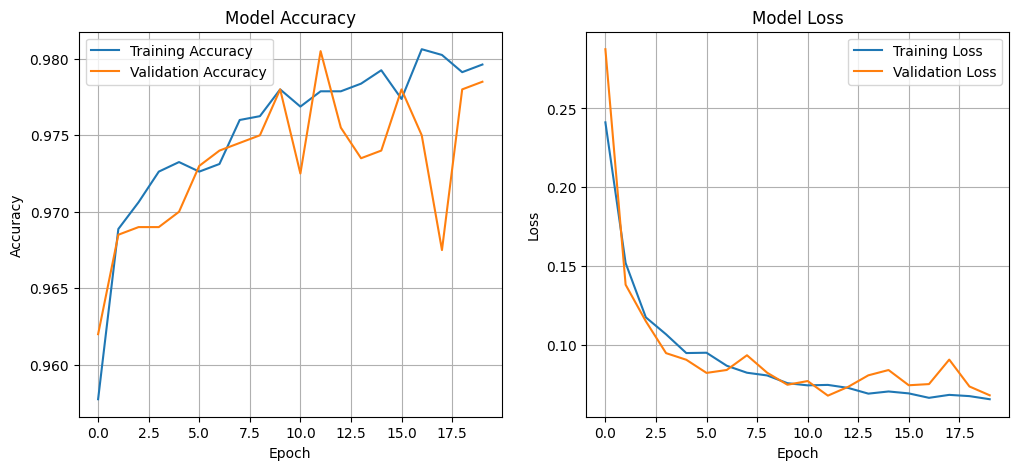

In [9]:
# 결과 1: 훈련/검증 곡선
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.savefig('training_history.png')
print("결과 1: 훈련/검증 곡선 'training_history.png' 저장 완료.")
plt.show()

In [10]:
# 결과 2: 테스트 데이터 최종 평가
print("\n--- 테스트 데이터 최종 평가 ---")
loss, accuracy = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


--- 테스트 데이터 최종 평가 ---
Test Loss: 0.0680
Test Accuracy: 0.9785


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- 분류 리포트 (Classification Report) ---
              precision    recall  f1-score   support

  No Failure       0.99      0.98      0.99      1932
     Failure       0.65      0.79      0.72        68

    accuracy                           0.98      2000
   macro avg       0.82      0.89      0.85      2000
weighted avg       0.98      0.98      0.98      2000


--- 혼동 행렬 (Confusion Matrix) ---
결과 3: 혼동 행렬 'confusion_matrix.png' 저장 완료.


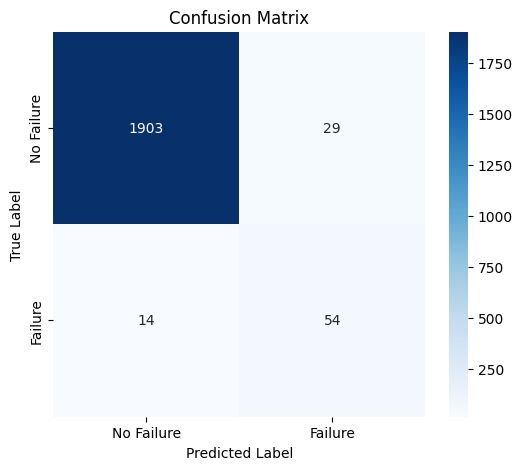

In [11]:
# 결과 3: 분류 리포트 및 혼동 행렬
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\n--- 분류 리포트 (Classification Report) ---")
print(classification_report(y_test, y_pred, target_names=['No Failure', 'Failure']))

print("\n--- 혼동 행렬 (Confusion Matrix) ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png')
print("결과 3: 혼동 행렬 'confusion_matrix.png' 저장 완료.")
plt.show()